# Description SVM training

In this version, the training is done using only the description in the dataset

In [43]:
import nltk
import time
import math
import tqdm
import json
import spacy
import joblib
import requests
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from itertools import product
from bs4 import BeautifulSoup
from wikidata.client import Client
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/epicmusk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/epicmusk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/epicmusk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/epicmusk/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Collecting data

In [44]:
# Sistemare i path per la consegna
dir_path   =  "/mnt/c/Users/fede6/Desktop/AI_R/Formazione/MNLP/HW1/"
train_path =  dir_path + "train.csv"
dev_path   =  dir_path + "valid.csv"

train_df = pd.read_csv(train_path, encoding='utf-8')
dev_df = pd.read_csv(dev_path, encoding='utf-8')

In [45]:
def save_txt(filename, path, txt):
    with open(path + filename, 'w', encoding='utf-8') as output:
        json.dump(txt, output, ensure_ascii=False, indent=2)

def load_txt(filename, path):
    with open(path + filename, 'r', encoding='utf-8') as input_file:
        return json.load(input_file)
    
train_txt = load_txt(filename="train_paragraphs.txt", path=dir_path)
valid_txt = load_txt(filename="dev_paragraphs.txt", path=dir_path)

In [46]:
train_df['paragraph'] = train_txt
dev_df['paragraph'] = valid_txt

In [47]:
train_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,916 is a 2012 Indian Malayalam -language drama...
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,¡Soborno! (English: Bribery! ) is a 1977 comic...
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,+44 (read as Plus Forty-four ) was an American...
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,"1 Monk Street, Monmouth was built as a Working..."


In [48]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,A Gang Story ( French : Les Lyonnais ) is a 20...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l..."


## TF-IDF computation

Definition of the vocabulary

In [49]:
UNK_TOKEN = '<UNK>'
STOPWORDS = set(stopwords.words('english'))
ENGLISH_WORDS = set(words.words())
REMOVED_WORDS = ['ˈ', 'also', 'since', 'many']
lemmatizer = WordNetLemmatizer()

features = load_txt(filename="MostInfluentWords.txt", path=dir_path)

def get_penal_words(features):
    penalization_words = []
    suspicious_words = defaultdict(list)

    for label, word_weights in features.items():
        for word, weight in word_weights:
            if (
                word.lower() not in ENGLISH_WORDS and 
                word.lower() not in STOPWORDS
            ):
                suspicious_words[label].append((word, weight))

    for label, words in suspicious_words.items():
        for word, score in words:
            penalization_words.append(word)
    return penalization_words

for word in REMOVED_WORDS:
    STOPWORDS.add(word)

penalization_words = get_penal_words(features)


In [50]:
penalization_words

['esperanto',
 'pennine',
 'others',
 'christianity',
 'using',
 'english',
 'olympic',
 'mont',
 'larger',
 'sugarcane',
 'mailing',
 'asia',
 'plc',
 'oficio',
 'internationaal',
 'esperantisto',
 'oth',
 'inclined',
 'christianiki',
 'highrise',
 'penn',
 'perske',
 'humacao',
 'olympia',
 'aso',
 'esperanto',
 'olympic',
 'sony',
 'sugarcane',
 'plc',
 'online',
 'using',
 'parapan',
 'esperantisto',
 'olympia',
 'inclined',
 'planoisiennes',
 'internationaal',
 'anorodi',
 'pellisier',
 'engelskirchen',
 'friedrich',
 'leipzig',
 'died',
 'egyptian',
 'nirmal',
 'accompanied',
 'amft',
 'appeared',
 'competed',
 'swedish',
 'quebec',
 'der',
 'honden',
 'appointed',
 'orientis',
 'russes',
 'sociales',
 'friedman',
 'newsgathering',
 'leinster',
 'soundstage',
 'reife',
 'tradicionale',
 'schlüter']

In [51]:
print(f"Percentage of penalized word w.r.t. vocabulary size {(100*len(penalization_words)/(37945)):.2f}%")

Percentage of penalized word w.r.t. vocabulary size 0.17%


Implementation of methods to compute the TF-IDF

In [52]:
def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

def tf(doc):
    tf_ = {}
    words = tokenize(doc)
    cnt = Counter(words)
    normalization_factor = len(words)
    for word, occs in cnt.items():
        tf_[word] = occs / normalization_factor
        
    return tf_

def idf(texts):
    idf_ = {}
    N = len(texts)
    tokenized_docs = [set(tokenize(doc)) for doc in texts]
    all_words = set(word for doc in tokenized_docs for word in doc)
    
    for word in tqdm.tqdm(all_words):
        doc_cnt = sum(1 for doc in tokenized_docs if word in doc)
        idf_[word] = math.log((1 + N) / (1 + doc_cnt)) + 1
    return idf_

def idf_by_category(df):
    categorical_idf = {}
    grouped = df.groupby('category')['paragraph'].apply(list)

    for cat, docs in grouped.items():
        categorical_idf[cat] = idf(docs)

    return categorical_idf

def tf_idf(tf_, idf_, word_index=None, unk_token=UNK_TOKEN):
    tfidf = {}
    unk_val = 0.0

    for word, tf_val in tf_.items():
        idf_val = idf_.get(word, 1.0)
        penalty = 0.3 if word in penalization_words else 1.0
        value = tf_val * idf_val * penalty

        if word_index is not None and word not in word_index:
            unk_val += value
        else:
            tfidf[word] = value

    if word_index is not None and unk_token in word_index:
        tfidf[unk_token] = unk_val

    return tfidf

def vectorize(tfidf_dict, word_index, unk_token=UNK_TOKEN):
    vec = np.zeros(len(word_index))
    unk_idx = word_index.get(unk_token)
    
    for word, value in tfidf_dict.items():
        if word in word_index:
            vec[word_index[word]] = value
        elif unk_idx is not None:
            vec[unk_idx] += value
    return vec

In [53]:
idf_cat = idf_by_category(train_df)
train_tfidfs = []
dev_tfidfs = []

for _, row in tqdm.tqdm(train_df.iterrows(), total=len(train_df), colour='green'):
    doc = row['paragraph']
    cat = row['category']
    tf_ = tf(doc)
    idf_ = idf_cat.get(cat, {})
    tfidf = tf_idf(tf_, idf_)
    train_tfidfs.append(tfidf)

train_df['tf_idf'] = train_tfidfs

100%|█████████████████████████████████████████████████████████████████████| 6251/6251 [00:06<00:00, 938.89it/s]


In [54]:
train_df.head()

,item,name,description,type,category,subcategory,label,paragraph,tf_idf
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,916 is a 2012 Indian Malayalam -language drama...,"{'indian': 0.21848465862592362, 'malayalam': 0..."
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...,"{'tʃ': 0.4018646570636401, 'ɪ': 0.303772652926..."
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,¡Soborno! (English: Bribery! ) is a 1977 comic...,"{'english': 0.05184223924600517, 'bribery': 0...."
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,+44 (read as Plus Forty-four ) was an American...,"{'read': 0.0885609174389895, 'plus': 0.0947988..."
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,"1 Monk Street, Monmouth was built as a Working...","{'monk': 0.13384657659845203, 'street': 0.0940..."


In [55]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,A Gang Story ( French : Les Lyonnais ) is a 20...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l..."


## Label Mapping

In [56]:
labels = {
    'cultural exclusive': 0,
    'cultural agnostic': 1,
    'cultural representative': 2
}

train_df['label'] = train_df['label'].map(labels)
dev_df['label'] = dev_df['label'].map(labels)

In [57]:
train_df.head(10)

,item,name,description,type,category,subcategory,label,paragraph,tf_idf
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,0,916 is a 2012 Indian Malayalam -language drama...,"{'indian': 0.21848465862592362, 'malayalam': 0..."
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,2,!!! ( / tʃ ( ɪ ) k . tʃ ( ɪ ) k . tʃ ( ɪ ) k /...,"{'tʃ': 0.4018646570636401, 'ɪ': 0.303772652926..."
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,2,¡Soborno! (English: Bribery! ) is a 1977 comic...,"{'english': 0.05184223924600517, 'bribery': 0...."
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,2,+44 (read as Plus Forty-four ) was an American...,"{'read': 0.0885609174389895, 'plus': 0.0947988..."
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,0,"1 Monk Street, Monmouth was built as a Working...","{'monk': 0.13384657659845203, 'street': 0.0940..."
5,http://www.wikidata.org/entity/Q104414508,100 percent corner,term for city center,concept,geography,city,1,The 100 percent corner is the busiest area in ...,"{'percent': 0.36748232531932407, 'corner': 0.2..."
6,http://www.wikidata.org/entity/Q3008535,1889 Apia cyclone,Category 1 South Pacific cyclone in 1889,entity,history,historical event,1,The 1889 Apia cyclone was a tropical cyclone i...,"{'apia': 0.44645663674425673, 'cyclone': 0.446..."
7,http://www.wikidata.org/entity/Q85720601,18th Abduction,novel by James patterson,entity,books,book,1,18th Abduction is the eighteenth novel in the ...,"{'abduction': 0.07735476400479083, 'eighteenth..."
8,http://www.wikidata.org/entity/Q105570,20 July plot,"attempt to assassinate Adolf Hitler, 1944",entity,history,historical event,0,The 20 July plot was a failed attempt to assas...,"{'july': 0.14860228057426672, 'plot': 0.111614..."
9,http://www.wikidata.org/entity/Q434841,20th Century Studios,American film studio owned by The Walt Disney ...,entity,media,film studio,2,"20th Century Studios, Inc. , formerly 20th Cen...","{'century': 0.2661310336263426, 'studio': 0.32..."


In [58]:
dev_df.head()

,item,name,description,type,category,subcategory,label,paragraph
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,2,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,0,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,2,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,0,A Gang Story ( French : Les Lyonnais ) is a 20...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,2,"Aaron Copland ( / ˈ k oʊ p l ə n d / , KOHP -l..."


## Test SVM

#### One-Hot-Encoding + Categorical TF-IDF

In [59]:
cols_to_encode = ['type', 'subcategory']

encoder = OneHotEncoder(handle_unknown='ignore')
onehotvec_train = encoder.fit_transform(train_df[cols_to_encode]).toarray().astype(float)

onehotvec_valid = encoder.transform(dev_df[cols_to_encode]).toarray().astype(float)

dictionary = train_df['tf_idf'].to_list()

vocab = sorted(set(word for doc in train_df['paragraph'] for word in tokenize(doc)))
word_index = {word: idx for idx, word in enumerate(vocab)}
word_index[UNK_TOKEN] = len(word_index)

for _, row in tqdm.tqdm(dev_df.iterrows(), total=len(dev_df), colour='green'):
    doc = row['paragraph']
    cat = row['category']
    tf_ = tf(doc)
    idf_ = idf_cat.get(cat, {})
    tfidf = tf_idf(tf_, idf_, word_index=word_index, unk_token=UNK_TOKEN)
    dev_tfidfs.append(tfidf)
dev_df['tf_idf'] = dev_tfidfs

val_docs = dev_df['tf_idf'].to_list()

X = np.array([vectorize(doc_tfidf, word_index, unk_token=UNK_TOKEN) for doc_tfidf in dictionary])
X_val = np.array([vectorize(doc_tfidf, word_index, unk_token=UNK_TOKEN) for doc_tfidf in val_docs])
y = np.array(train_df['label'])
y_val = np.array(dev_df['label'])

X = np.hstack([X, onehotvec_train])
X_val = np.hstack([X_val, onehotvec_valid])

100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 919.92it/s]


## Weights computation

In [60]:
freq_dict = {
    1: 0.2995, # cultural agnostic
    2: 0.2700, # cultural representative
    0: 0.4305  # cultural exclusive
}

def weights_computation(freq_dict):
    weights = {k: 1/v for k, v in freq_dict.items()}
    norm_factor = sum(weights.values())
    norm_weights = {k: v/norm_factor for k, v in weights.items()}
    return norm_weights

## Paragraph training

In [61]:
GRIDSEARCH = False

In [ ]:
C_values = [7]
gamma = 'scale'
kernels = ['linear']

best_score = 0
best_params = {}
best_model = None

class_weights = weights_computation(freq_dict)

for kernel, C in product(kernels, C_values):
    print(f"Testing: C={C}, gamma={gamma}, kernel={kernel}")
    
    svc = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weights, probability=True)
    
    try:
        svc.fit(X, y)

        y_pred = svc.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        print(f"Accuracy: {score:.4f}")
        print(f"F1 macro score: {f1_score(y_val, y_pred, average='macro'):.4f}")

        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            best_model = svc

    except Exception as e:
        print(f"ERROR! Params:\tC={C}, gamma={gamma}, kernel={kernel}: {e}")
        
GRIDSEARCH = True

Testing: C=5, gamma=scale, kernel=linear
Accuracy: 0.7067
F1 macro score: 0.6888
Testing: C=6, gamma=scale, kernel=linear


In [62]:
if GRIDSEARCH:
    print("Best parameters found:", best_model)
    y_pred = best_model.predict(X_val)
    print(classification_report(y_val, y_pred))
else:
    best_model = joblib.load(dir_path + "PenaltySVM_OOV.pkl")
    print("Best parameters found:", best_model)
    y_pred = best_model.predict(X_val)
    print(classification_report(y_val, y_pred))

Best parameters found: SVC(C=7,
    class_weight={0: 0.24802570891599746, 1: 0.3565110774234955,
                  2: 0.395463213660507},
    kernel='linear')
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        76
           1       0.83      0.86      0.85       117
           2       0.73      0.62      0.67       107

    accuracy                           0.74       300
   macro avg       0.72      0.73      0.72       300
weighted avg       0.74      0.74      0.74       300



In [64]:
print(f"Accuracy:\t {best_model.score(X_val, y_val):.4f}")

Accuracy:	 0.7367


In [27]:
joblib.dump(best_model, dir_path + "PenaltySVM_OOV.pkl")

['/mnt/c/Users/fede6/Desktop/AI_R/Formazione/MNLP/HW1/PenaltySVM_OOV.pkl']

## SVC weights analysis

In [25]:
classes = ['agnostic', 'representative', 'exclusive']
tfidf_size = len(word_index)
reverse_word_index = {v: k for k, v in word_index.items()}
threshold = 1.1

most_influent_words = {
    'agnostic': [],
    'representative': [],
    'exclusive': []
}

for i, class_name in enumerate(classes):
    top_features = np.argsort(best_model.coef_[i])[::-1]
    
    for feat_idx in top_features:
        if feat_idx < tfidf_size:            
            word = reverse_word_index[feat_idx]
            weight = best_model.coef_[i][feat_idx]          
            if weight < threshold:
                break
            else:
                most_influent_words[class_name].append((word, round(weight, 4)))

In [26]:
save_txt("MostInfluentWords.txt", path=dir_path, txt=most_influent_words)

## Mispredictions analysis

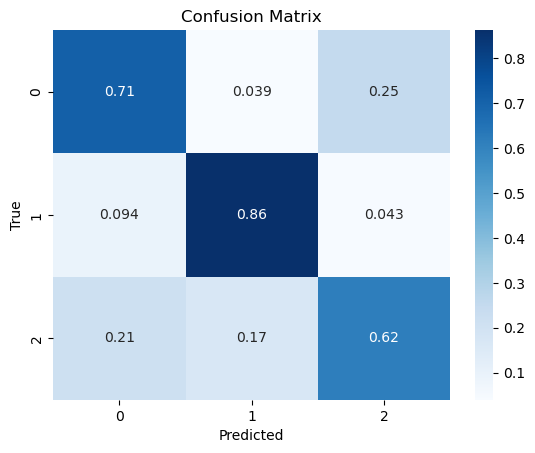

In [65]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
labels = np.unique(y_val)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [66]:
error_df = dev_df.copy()
error_df['true_label'] = y_val
error_df['predicted'] = y_pred
error_df['correct'] = error_df['true_label'] == error_df['predicted']

mistakes = error_df[~error_df['correct']]

mistakes[['name', 'tf_idf', 'true_label', 'predicted']].sample(20, random_state=42)

,name,tf_idf,true_label,predicted
115,Geneva Open Challenger,"{'geneva': 0.045454545454545456, 'open': 0.097...",2,0
0,1. FC Nürnberg,"{'verein': 0.01639344262295082, 'für': 0.01639...",2,0
86,Dione Lucas,"{'lucas': 0.06451612903225806, 'pronounced': 0...",0,2
116,geoponici,"{'latinized': 0.043478260869565216, 'form': 0....",2,0
78,Cultural Revolution,"{'cultural': 0.2282983273735388, 'revolution':...",2,0
109,Francis Coventry,"{'francis': 0.18800020263869077, 'k': 0.150037...",0,2
38,Bauhaus Archive,"{'bauhaus': 0.06451612903225806, 'archive': 0....",2,0
262,Studio 4°C,"{'studio': 0.2942062602061816, 'stylized': 0.2...",0,2
17,Anasyrma,"{'ancient': 0.08568732836275197, 'greek': 0.10...",2,1
46,Boomerang,"{'american': 0.0875463996938888, 'cable': 0.18...",0,2


In [67]:
mistakes_per_label = mistakes.groupby('true_label')['predicted'].value_counts().unstack(fill_value=0)
mistakes_per_label

predicted,0,1,2
true_label,,,
0,0,3,19
1,11,0,5
2,23,18,0


In [68]:
tokens_errors = [token for doc in mistakes['paragraph'] for token in tokenize(doc)]
common_error_words = Counter(tokens_errors).most_common(50)
print("Most common words in misclassified samples:")
print(common_error_words)

Most common words in misclassified samples:
[('music', 20), ('dance', 18), ('party', 18), ('known', 16), ('style', 15), ('world', 14), ('term', 14), ('city', 14), ('film', 14), ('century', 13), ('political', 13), ('ancient', 12), ('used', 12), ('festival', 12), ('european', 12), ('folk', 12), ('first', 11), ('time', 11), ('german', 10), ('arabic', 10), ('greek', 10), ('japan', 10), ('song', 10), ('including', 9), ('population', 9), ('work', 9), ('role', 9), ('state', 9), ('french', 9), ('group', 9), ('building', 9), ('london', 9), ('often', 8), ('founded', 8), ('island', 8), ('area', 8), ('people', 8), ('animation', 8), ('form', 8), ('traditional', 8), ('network', 8), ('catholic', 8), ('church', 8), ('religion', 8), ('lyric', 8), ('pit', 8), ('africa', 7), ('name', 7), ('italian', 7), ('company', 7)]


In [69]:
classes_mistakes = defaultdict(list)

for _, row in mistakes.iterrows():
    tokens = tokenize(row['paragraph'])
    classes_mistakes[row['label']].extend(tokens)

class_tokens = defaultdict(list)

for _, row in dev_df.iterrows():
    tokens = tokenize(row['paragraph'])
    class_tokens[row['label']].extend(tokens)

class_er = {}

for class_label in classes_mistakes:
    error_counts = Counter(classes_mistakes[class_label])
    total_counts = Counter(class_tokens[class_label])
    
    token_rates = {}
    for token, err_count in error_counts.items():
        total = total_counts.get(token, 1)
        token_rates[token] = [err_count / total, err_count, total]

    class_er[class_label] = dict(sorted(token_rates.items(), key=lambda x: x[1][0], reverse=True))
    

In [ ]:
def see_mistakes(cl, word, mistakes_vocab=class_er):
    print(f"Mistakes with '{word}' on: '{cl}'")
    print(mistakes_vocab[cl][word])

classes = [0, 1, 2]
for cl in classes:
    try:
        word = 'music'
        see_mistakes(cl, word=word)
    except Exception as e:
        if isinstance(e, KeyError):
            print(f"The word {e} is not in the mistakes vocabulary")
        else:
            print(f"ERROR! Error in the mistake dictionary {e}")
    

Mistakes with 'music' on: '0'
[0.14285714285714285, 1, 7]
Mistakes with 'music' on: '1'
[0.5, 15, 30]
Mistakes with 'music' on: '2'
[0.4, 4, 10]


In [72]:
mistakes.groupby('category').size().sort_values(ascending=False).head(10)

category
history                    8
politics                   6
philosophy and religion    6
music                      6
books                      5
architecture               5
media                      5
films                      5
literature                 5
performing arts            5
dtype: int64

In [73]:
mistakes.groupby('subcategory').size().sort_values(ascending=False).head(10)

subcategory
museum                 3
religion               3
acting style           2
book                   2
geographic location    2
government             2
dance                  2
film genre             2
musical group          2
animation studio       2
dtype: int64